## Cloud Detection

Detect clouds from the merged images.

**Input**: Merged images

**Output**: Cloud probabilites and masks for each date in `data/interim/cloud_cover/{date}/mask_{resolution}m.jp2`

**Example output:**

For 20m resolution on date '2017-02-10': 
- `data/interim/cloud_cover/2017-02-10/mask_20m.jp2`

In [1]:
import numpy as np

from sentinelhub import AwsProductRequest
from config import interim_data_dir

import rasterio
from rasterio.enums import Resampling

from tqdm import tqdm

resolution_groups = {
    60: ['B01', 'B09', 'B10'],
    20: ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12'],
    10: ['B02', 'B03', 'B04', 'B08']
}

bands = ['B01','B02','B04','B05','B08','B8A','B09','B10','B11','B12']

## Resample Images

**Current version:** `20m`

In [2]:
OUT_RESOLUTION=20

# Get shape of raster
with rasterio.open(interim_data_dir / 'images-merged' / '2017-02-10'/'B05.jp2') as raster:
    data = raster.read()
    
data.shape

(1, 5490, 10491)

In [3]:
img_shape = (5490, 10491)


def return_empty(shape):
    return np.zeros(shape=(1, *shape, 10))


def resample(raster, out_shape):
    
    return raster.read(
        1, 
        out_shape=out_shape,
        resampling=Resampling.bilinear
    )

def process_bands(res_group, out_shape, images_dir, all_bands_data):
    
    for band in tqdm(resolution_groups[res_group], desc=str(res_group)):
        
        if band not in bands:
            continue
        
        band_index = bands.index(band)
        
        if res_group == OUT_RESOLUTION:
            with rasterio.open(images_dir / f'{band}.jp2') as raster:
                all_bands_data[0, :, :, band_index] = raster.read(1)
        
        else:
            with rasterio.open(images_dir / f'{band}.jp2') as raster:
                all_bands_data[0, :, :, band_index] = raster.read(
                    1,
                    out_shape=img_shape,
                    resampling=Resampling.bilinear,
                )



def get_all_bands_data(output_shape, date):
    
    images_dir = interim_data_dir / 'images-merged' / date
    
    # Will contain resampled data
    all_bands_data = return_empty(output_shape)

    process_bands(10, img_shape, images_dir, all_bands_data)
    
    process_bands(20, img_shape, images_dir, all_bands_data)
    
    process_bands(60, img_shape, images_dir, all_bands_data)
    
    # Convert data to reflectances
    all_bands_data = np.divide(all_bands_data, 10000.0)
    
    # Save some ram
    all_bands_data = all_bands_data.astype(np.float32)
    
    return all_bands_data
        

In [61]:
%%time
all_bands_data = get_all_bands_data(img_shape, date='2017-02-10')

60: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


CPU times: user 56.2 s, sys: 6.3 s, total: 1min 2s
Wall time: 21.4 s


Seems to get data in the right order

## Implement cloud detection

In [4]:
from s2cloudless import S2PixelCloudDetector

cloud_detector = S2PixelCloudDetector(average_over=4, dilation_size=2)

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [63]:
%%time

thresh=0.4
print('Creating masks from probs with thresh: ', thresh, end='')
cloud_mask = cloud_detector.get_cloud_masks(all_bands_data)
print('done')

Creating masks from probs with thresh:  0.4done
CPU times: user 30min 58s, sys: 8.86 s, total: 31min 7s
Wall time: 3min


In [84]:
cloud_mask = cloud_mask.astype('uint8')

### Show RGB image with cloud probs and mask

In [5]:
import matplotlib.pyplot as plt

def show_img_and_mask(rgb_image, mask, figsize=(15, 40)):
    """
    Utility function for plotting a RGB image and its cloud probability map next to each other. 
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    ax=axes[0]
    ax.imshow(rgb_image)
    
    ax=axes[1]
    ax.set_title('Mask')
    ax.imshow(mask, cmap=plt.cm.gray)
    
    plt.show()

In [91]:
images_dir = interim_data_dir / 'images-merged' / '2017-02-10'

# Load RGB image
with rasterio.open(images_dir / 'TCI.jp2') as raster:
    
    rgb_img = raster.read(
            out_shape=(raster.count, *img_shape),
            resampling=Resampling.bilinear,
        )
    
    rgb_img = np.moveaxis(rgb_img, 0, 2)

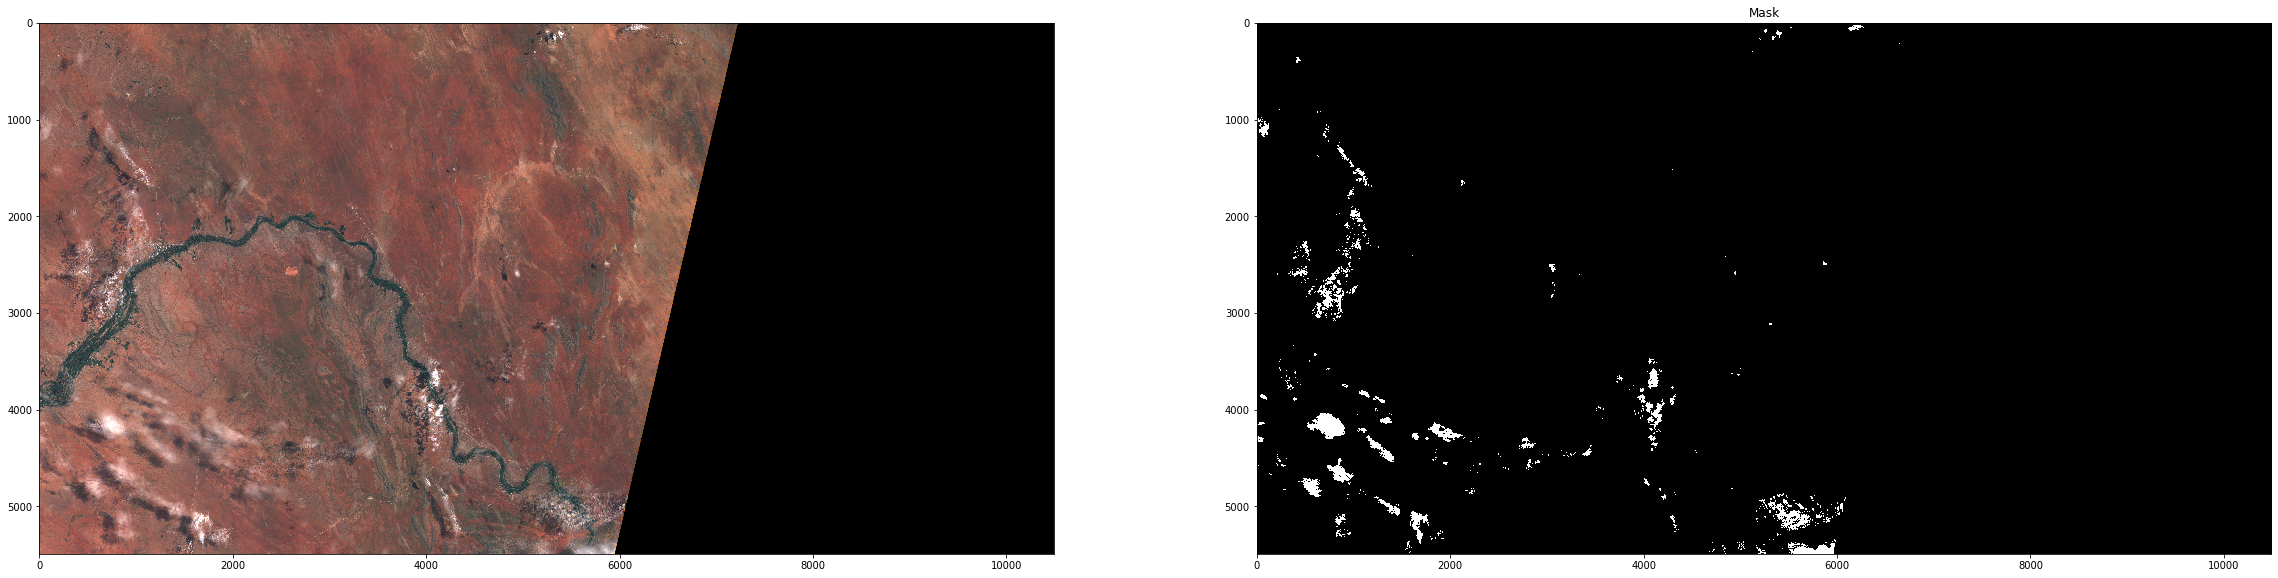

In [92]:
show_img_and_mask(rgb_img, cloud_mask[0], figsize=(40, 60))

**Looks good!!**

### Save cloud masks as JP2 image

In [6]:
# First, get the meta data from a 20m resolution raster
# Load RGB image

def get_meta(res):
    band = resolution_groups[res][0]
    raster =  rasterio.open(images_dir / f'{band}.jp2') 

    meta = raster.profile

    meta['count'] = 1
    meta['dtype'] = 'uint8'
    
    raster.close()
    
    return meta

meta = get_meta(res=20)

# Save masks and probs to disk
output_dir = interim_data_dir / 'cloud_masks' / '2017-02-10'
safe_create_dir(output_dir)

f_out_mask = output_dir / f'mask_20m.jp2'

with rasterio.open(f_out_mask, 'w', **meta) as mask_raster:
    mask_raster.write(cloud_mask)

NameError: name 'images_dir' is not defined

In [95]:
pprint(meta)

{'blockxsize': 1024,
 'blockysize': 1024,
 'count': 1,
 'crs': CRS.from_epsg(32734),
 'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'height': 5490,
 'nodata': None,
 'tiled': True,
 'transform': Affine(20.0, 0.0, 499980.0,
       0.0, -20.0, 6900040.0),
 'width': 10491}


# Now run for all dates

In [7]:
from src.utils import safe_create_dir
import gc

In [55]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' 
    By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254
    '''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                all_bands_data:   2.1GiB
                           ___: 439.4MiB
                           _10: 439.4MiB
                          data: 109.9MiB
                    cloud_mask:  54.9MiB
                          tqdm:   2.0KiB
                          _i44:   1.7KiB
                          _i25:   1.6KiB
                          _i26:   1.6KiB
                          _i19:   1.4KiB


In [9]:
all_dates = [
    "2017-01-01",
    "2017-01-31",
    "2017-02-10",
    "2017-03-12",
    "2017-03-22",
    "2017-05-31",
    "2017-06-20",
    "2017-07-10",
    "2017-07-15",
    "2017-08-04",
    "2017-08-19",
]

dates_w_clouds = [
#     '2017-02-10',
    '2017-08-04',
    '2017-08-19'
]

# If resolution changes, img_shape should also change
OUT_RESOLUTION=20
img_shape = (5490, 10491)

for date in all_dates:
    
    images_dir = interim_data_dir / 'images-merged' / date
    
    print('-'*40,date,'-'*40)
    
    output_dir = interim_data_dir / 'cloud_masks'
    safe_create_dir(output_dir)
    
    if date not in dates_w_clouds:
        print('skipping...')
        continue

    
    bands_data = get_all_bands_data(img_shape, date)

    cloud_detector = S2PixelCloudDetector(average_over=4, dilation_size=2)

    thresh=0.4
    print('Creating masks...', end='')
    cloud_mask = cloud_detector.get_cloud_masks(bands_data)
    cloud_mask = cloud_mask.astype('uint8')
    print('done')

#     # Show detected clouds
#     # Load RGB image
#     with rasterio.open(images_dir / 'TCI.jp2') as raster:
#         rgb_img = raster.read(
#                 out_shape=(raster.count, *img_shape),
#                 resampling=Resampling.bilinear,
#             )
#         rgb_img = np.moveaxis(rgb_img, 0, 2)
        
#     show_img_and_mask(rgb_img, cloud_mask[0], figsize=(40, 60))

    meta = get_meta(res=20)

    meta['count'] = 1
    
    # Save masks and probs to disk
    output_dir = interim_data_dir / 'cloud_masks' / date
    safe_create_dir(output_dir)

    f_out_mask = output_dir / f'mask_{OUT_RESOLUTION}m.jp2'
    
    with rasterio.open(f_out_mask, 'w', **meta) as mask_raster:
        mask_raster.write(cloud_mask)
    
    
    del bands_data
    del cloud_mask
    gc.collect()
    

10:   0%|          | 0/4 [00:00<?, ?it/s]

---------------------------------------- 2017-01-01 ----------------------------------------
skipping...
---------------------------------------- 2017-01-31 ----------------------------------------
skipping...
---------------------------------------- 2017-02-10 ----------------------------------------
skipping...
---------------------------------------- 2017-03-12 ----------------------------------------
skipping...
---------------------------------------- 2017-03-22 ----------------------------------------
skipping...
---------------------------------------- 2017-05-31 ----------------------------------------
skipping...
---------------------------------------- 2017-06-20 ----------------------------------------
skipping...
---------------------------------------- 2017-07-10 ----------------------------------------
skipping...
---------------------------------------- 2017-07-15 ----------------------------------------
skipping...
---------------------------------------- 2017-08-04 ---

60: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


Creating masks...done


10:   0%|          | 0/4 [00:00<?, ?it/s]

---------------------------------------- 2017-08-19 ----------------------------------------


60: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it]


Creating masks...done
